In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def compute_matrices(U,N):
    h=1/(N-1)
    D1=np.diag(np.ones(N-1),-1)-np.diag(np.ones(N-1),1)
    D1[0,-1]=1.    
    D1[-1,0]=-1.
    D1*=U/2/h
    # MPP artificial viscosity operator #
    DL=D1*0
    for i in range(N):
        for j in np.arange(i+1,N):
            DL[i,j]=np.max([-D1[i,j],0,-D1[j,i]])
            DL[j,i]=DL[i,j]
        DL[i,i]=-np.sum(DL[i,:])
        
    return D1,DL

In [3]:
def sdisc(u,D1,DL,compute_flux_matrices=False):
    fG = np.dot(D1+DL,u)
    fB = np.dot(-DL,u)
    
    fijG = D1*0
    fijB = D1*0
    
    if compute_flux_matrices:
        for i in range(len(D1)):
            jVector = [len(D1)-1,i+1] if i==0 else ([0,i-1] if i==len(D1)-1 else [i-1,i+1])
            for j in jVector:
                fijG[i,j] = D1[i,j]*u[j]-D1[j,i]*u[i] + DL[i,j]*(u[j]-u[i])
                fijB[i,j] = -DL[i,j]*(u[j]-u[i])                
            #
        #
    #
    return fG+fB,fG,fB,fijG,fijB

In [4]:
def scaled_bad_flux(dt,un,fG,fB,global_bounds=False,single_gamma=False):
    gamma=0*fB
    for i in range(len(fB)):
        # compute bounds 
        if global_bounds:
            umax=1
            umin=0
        else:
            umax=np.max(un[i:i+2]) if i==0 else (np.max(un[i-1:i+1]) if i==len(fB)-1 else np.max(un[i-1:i+2]))
            umin=np.min(un[i:i+2]) if i==0 else (np.min(un[i-1:i+1]) if i==len(fB)-1 else np.min(un[i-1:i+2]))
        # compute limiters 
        gamma_neg = (umin-un[i]-dt*fG[i])/dt/fB[i] if (un[i]+dt*(fG[i]+fB[i])<umin and fB[i]!=0) else 1.0
        gamma_pos = (umax-un[i]-dt*fG[i])/dt/fB[i] if (un[i]+dt*(fG[i]+fB[i])>umax and fB[i]!=0) else 1.0
        gamma[i]=min(gamma_neg,gamma_pos)
    #
    if single_gamma:
        sfB=np.min(gamma)*fB
    else:
        sfB=np.multiply(gamma,fB)
    return sfB

In [19]:
def limited_conservative_flux(un,uL,fij,global_bounds=False):
    Rpos=un*0; Rneg=un*0; limited_flux_correction=un*0
    for i in range(len(un)):
        if global_bounds:
            umax=1
            umin=0
        else:
            umax=np.max(un[i:i+2]) if i==0 else (np.max(un[i-1:i+1]) if i==len(un)-1 else np.max(un[i-1:i+2]))
            umin=np.min(un[i:i+2]) if i==0 else (np.min(un[i-1:i+1]) if i==len(un)-1 else np.min(un[i-1:i+2]))
        jVector = [len(un)-1,i+1] if i==0 else ([0,i-1] if i==len(un)-1 else [i-1,i+1])
        Ppos=0; Pneg=0
        for j in jVector:
            # compute p vectors 
            Ppos += max(fij[i,j],0)
            Pneg += min(fij[i,j],0)
        # Compute R vectors 
        Rpos[i] = min(1.,(umax-uL[i])/Ppos) if Ppos!=0 else 1.0
        Rneg[i] = min(1.,(umin-uL[i])/Pneg) if Pneg!=0 else 1.0
    #
    # compute limited flux 
    for i in range(len(un)):
        #jVector = [len(un)-1,i+1] if i==0 else ([0,i-1] if i==len(un)-1 else [i-1,i+1])
        jVector = [i+1] if i==0 else ([i-1] if i==len(un)-1 else [i-1,i+1])
        for j in jVector:
            Lij = min(Rpos[i],Rneg[j]) if fij[i,j]>0 else min(Rneg[i],Rpos[j])
            limited_flux_correction[i] += Lij*fij[i,j]
        #
    #
    return limited_flux_correction

min value of (RK4 with low-order stab, MRK4)= 0.0 1.2969667084650409e-46
max value of (RK4 with low-order stab, MRK4)= 1.0 0.9934866933469505
loss in mass of (RK4 with low-order stab, RK4, MRK4)= 0.0 0.0 3.7007434154171886e-16


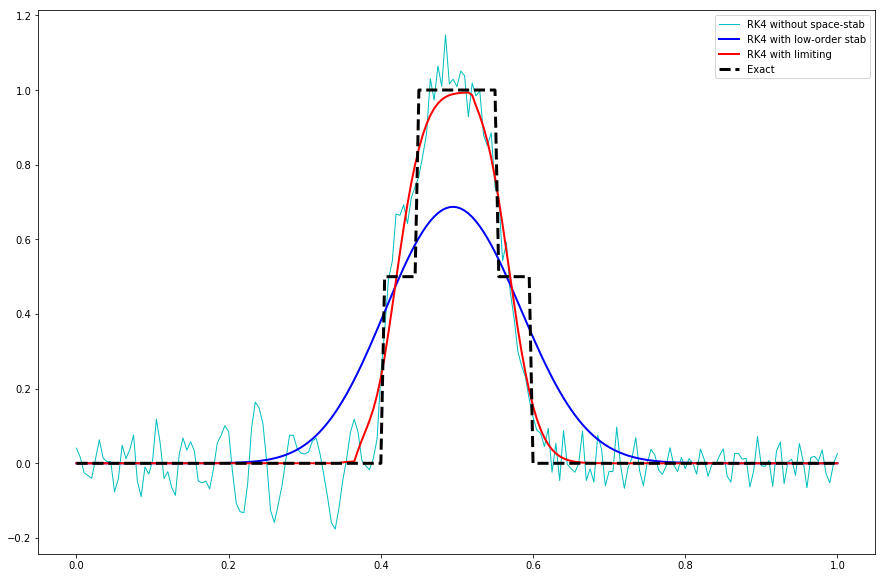

In [47]:
N=201

global_bounds=False
single_gamma=False
conservative=True

# physical parameters #
U=1
T=1.0
DT=0.1
x=np.linspace(0,1,N)

# Numerical parameters #
h=1./(N-1);
C=0.75
dt=C*h*U

# Initial conditions #
u0=1.0*(x>0.45)*(x<0.55)
u0=0.5*(x>0.4)*(x<0.45)+1.0*(x>=0.45)*(x<=0.55)+0.5*(x>0.55)*(x<0.6)
un_RK4=1.0*u0;
uLn_RK4=1.0*u0;
un_MRK4=1.0*u0;

(D1,DL)=compute_matrices(U,N)

initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu_MRK4 = np.zeros([len(u0),int(NT)+1])
uuL_RK4 = np.zeros([len(u0),int(NT)+1])
i=0
index=1
for t in times:
    # RK4 without stabilization in space
    f1,_,_,_,_=sdisc(un_RK4,D1,DL)
    f2,_,_,_,_=sdisc(un_RK4+0.5*dt*f1,D1,DL)
    f3,_,_,_,_=sdisc(un_RK4+0.5*dt*f2,D1,DL)
    f4,_,_,_,_=sdisc(un_RK4+dt*f3,D1,DL)
    unp1_RK4 = un_RK4 + dt/6.0*(f1+2*f2+2*f3+f4)
    
    # RK4 with low-order stabilization in space 
    f1,f1G,_,_,_=sdisc(uLn_RK4,D1,DL)
    f2,f2G,_,_,_=sdisc(uLn_RK4+0.5*dt*f1G,D1,DL)
    f3,f3G,_,_,_=sdisc(uLn_RK4+0.5*dt*f2G,D1,DL)
    f4,f4G,_,_,_=sdisc(uLn_RK4+dt*f3G,D1,DL)
    uLnp1_RK4 = uLn_RK4 + dt/6.0*(f1G+2*f2G+2*f3G+f4G)
    
    # MRK4: stabilization in space with limiters
    f1,f1G,f1B,f1ijG,f1ijB=sdisc(un_MRK4,D1,DL,compute_flux_matrices=True)
    f2,f2G,f2B,f2ijG,f2ijB=sdisc(un_MRK4+0.5*dt*f1,D1,DL,compute_flux_matrices=True)
    f3,f3G,f3B,f3ijG,f3ijB=sdisc(un_MRK4+0.5*dt*f2,D1,DL,compute_flux_matrices=True)
    f4,f4G,f4B,f4ijG,f4ijB=sdisc(un_MRK4+dt*f3,D1,DL,compute_flux_matrices=True)
    fG=f1G # good flux is given by forward Euler 
    
    if conservative:
        # conservative RK-FCT #
        fij=(-5*f1ijG+f1ijB + 2*(f2ijG+f2ijB) +2*(f3ijG+f3ijB) + f4ijG+f4ijB)/6.0
        sfB = limited_conservative_flux(un_MRK4,un_MRK4+dt*fG,dt*fij)
        unp1_MRK4 = (un_MRK4 + dt*fG) + sfB
    else:
        fB=(-5*f1G+f1B+2*f2+2*f3+f4)/6.0 # = (-5*f1G+f1B+2(f2G+f2B)+2(f3G+f3B)+(f4G+f4B))/6.0 bad flux are the other fluxes
        # Non-conservative scaled flux #
        sfB=scaled_bad_flux(dt,un_MRK4,fG,fB,global_bounds=global_bounds,single_gamma=single_gamma)   
        unp1_MRK4 = (un_MRK4 + dt*fG) + dt*sfB
    #
    # update old solution 
    un_RK4 = unp1_RK4
    uLn_RK4 = uLnp1_RK4
    un_MRK4 = unp1_MRK4

    # save solution for animation 
    uuL_RK4[:,i] = uLnp1_RK4
    uu_MRK4[:,i] = unp1_MRK4

    i+=1
#
loss_LRK4 = (initial_mass - h*np.sum(uLnp1_RK4))/initial_mass
loss_RK4 = (initial_mass - h*np.sum(unp1_RK4))/initial_mass
loss_MRK4 = (initial_mass - h*np.sum(unp1_MRK4))/initial_mass

print('min value of (RK4 with low-order stab, MRK4)=',np.min(uuL_RK4),np.min(unp1_MRK4))
print('max value of (RK4 with low-order stab, MRK4)=',np.max(uuL_RK4),np.max(unp1_MRK4))
print('loss in mass of (RK4 with low-order stab, RK4, MRK4)=',loss_LRK4,loss_RK4,loss_MRK4)

# plot final solutions #
plt.figure(figsize=([15,10])) 
plt.plot(x,unp1_RK4,'-c',linewidth=1)
plt.plot(x,uLnp1_RK4,'-b',linewidth=2)
plt.plot(x,unp1_MRK4,'-r',linewidth=2)
plt.plot(x,u0,'--k',linewidth=3)
plt.legend(['RK4 without space-stab','RK4 with low-order stab','RK4 with limiting','Exact'])
plt.show()
index+=1

# Standard CG + discrete upwinding + FCT

min, max value of (FCT solution)= 0.0 1.0
loss in mass with FCT solution= 1.628327102783563e-14


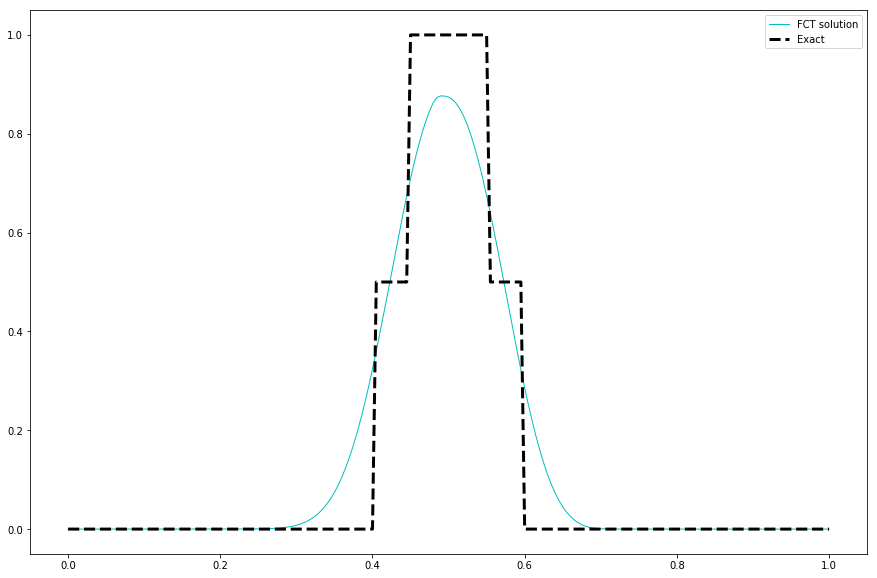

In [46]:
N=201

USE_FCT=True
global_bounds=False

# physical parameters #
U=1
T=1.0
DT=0.1
x=np.linspace(0,1,N)

# Numerical parameters #
h=1./(N-1);
C=0.75
dt=C*h*U

# Initial conditions #
u0=1.0*(x>0.45)*(x<0.55)
u0=0.5*(x>0.4)*(x<0.45)+1.0*(x>=0.45)*(x<=0.55)+0.5*(x>0.55)*(x<0.6)
un=1.0*u0;

(D1,DL)=compute_matrices(U,N)
initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu = np.zeros([len(u0),int(NT)+1])
i=0
index=1
for t in times:
    # First stage #
    f,fG,fB,fijG,fijB=sdisc(un,D1,DL,compute_flux_matrices=True) # spatial discretization
    sf = limited_conservative_flux(un,un+dt*fG,dt*fijB,global_bounds=global_bounds)/dt # limit anti-diffusive fluxes 
    u1 = un + dt*(fG + sf if USE_FCT else fB)
    
    # Second stage 
    f,fG,fB,fijG,fijB=sdisc(u1,D1,DL,compute_flux_matrices=True)
    sf = limited_conservative_flux(u1,u1+dt*fG,dt*fijB,global_bounds=global_bounds)/dt
    u2 = 3./4*un + 1./4*(u1 + dt*(fG + sf if USE_FCT else fB))
    
    # Third stage
    f,fG,fB,fijG,fijB=sdisc(u2,D1,DL,compute_flux_matrices=True)
    sf = limited_conservative_flux(u2,u2+dt*fG,dt*fijB,global_bounds=global_bounds)/dt
    u3 = 1./3*un + 2./3*(u2 + dt*(fG + sf if USE_FCT else fB))

    # update solution at new time step
    unp1 = u3
    
    # update old solution 
    un = unp1

    # save solution for animation 
    uu[:,i] = unp1
    i+=1
#
loss = (initial_mass - h*np.sum(unp1))/initial_mass

print('min, max value of (FCT solution)=',np.min(uu),np.max(uu))
print('loss in mass with FCT solution=',loss)

# plot final solutions #
plt.figure(figsize=([15,10]))
plt.plot(x,unp1,'-c',linewidth=1)
plt.plot(x,u0,'--k',linewidth=3)
plt.legend(['FCT solution','Exact'])
plt.show()
index+=1